In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import datetime
import os
import sys
sys.path.insert(0,"../HUXt/code")
sys.path.append('./orbitals_download/')
import importlib
import helpers
import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
import sunpy
from sunpy.coordinates import sun
import httplib2
from scipy.interpolate import interp1d
from pandas import Series
from astropy.time import Time


/opt/anaconda3/envs/huxt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### This notebook takes you through the first few steps of using HUXt. A link to the main example notebook is here: https://github.com/University-of-Reading-Space-Science/HUXt/blob/master/code/HUXt_examples.ipynb. 

### Task one: review this notebook, try running parts of it by copy pasting into this new notebook. 

-Identify where you create an input for the boundary condition. 

-Identify where you run the model. 

-Identify where you view the timeseries/radial profile. 

-Identify where you can view the 2D model output.  

-Identify where you can inject a CME. 

No initiation time specified. Defaulting to start of CR2000, 20/2/2003


(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'HUXt Radius: 214.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

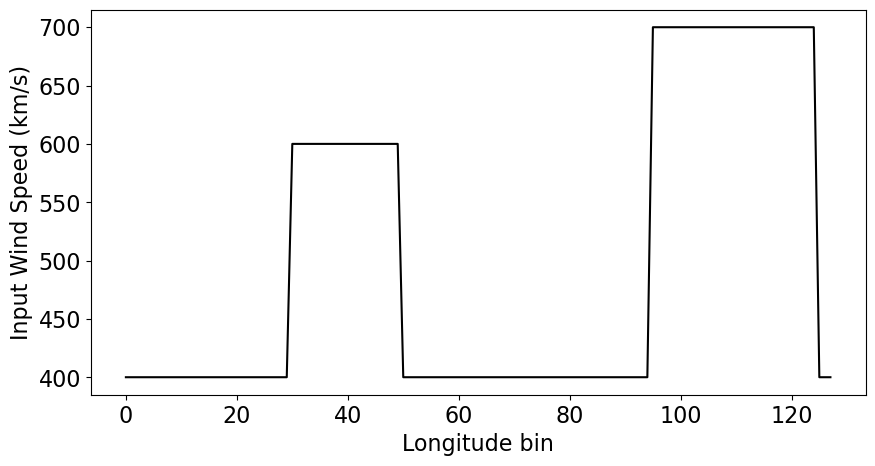

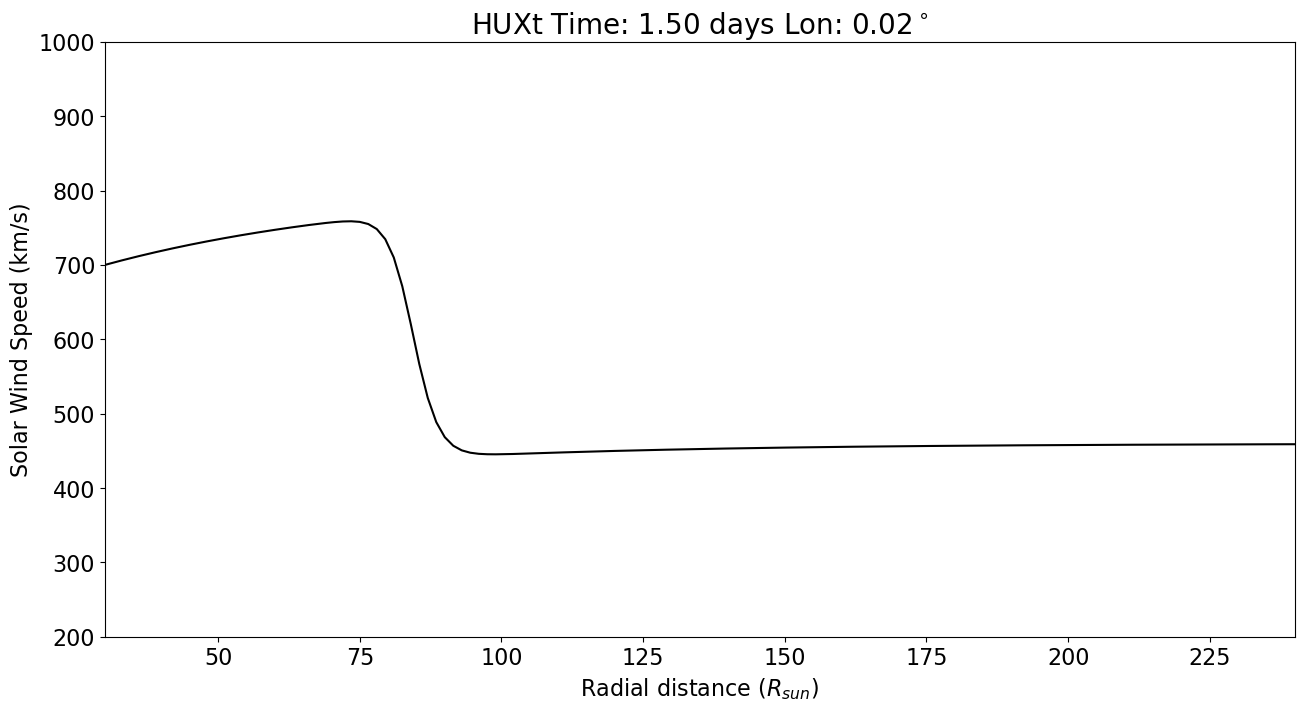

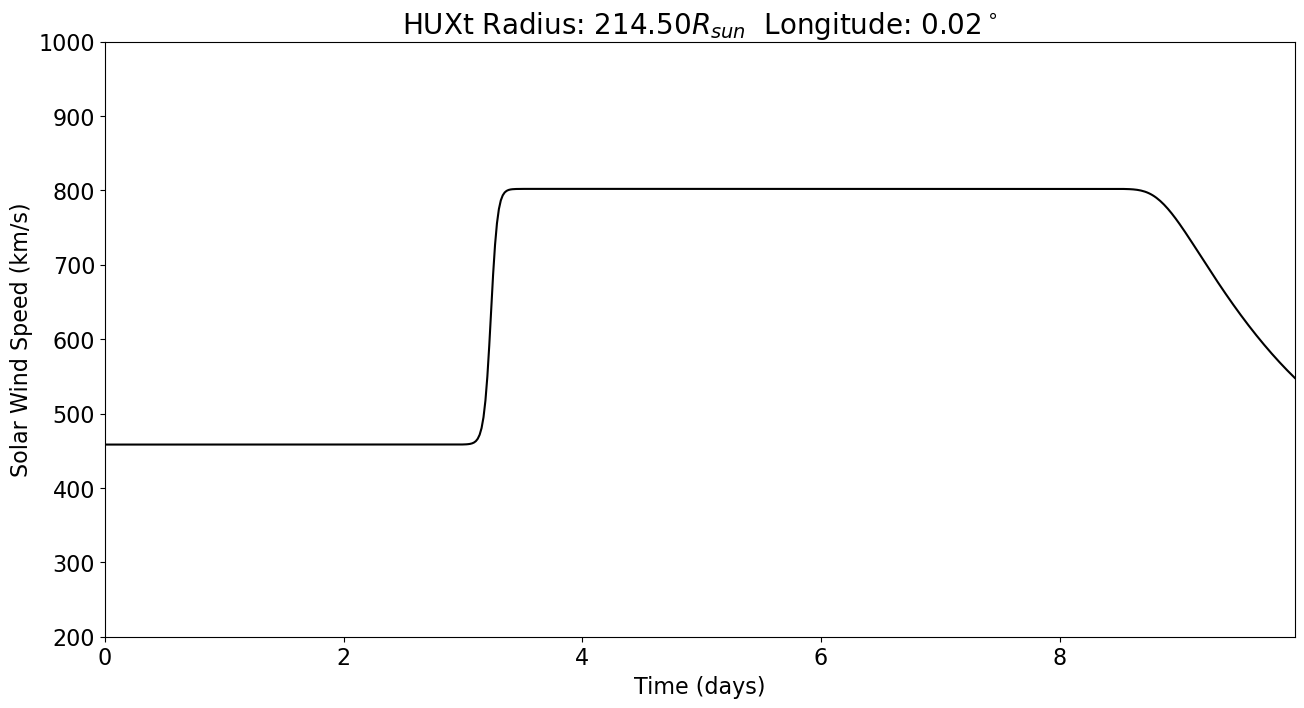

In [2]:
#EXAMPLE 1
#Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

# This boundary condition looks like
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(v_boundary,'k-')
ax.set_xlabel('Longitude bin')
ax.set_ylabel('Input Wind Speed (km/s)')

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=10*u.day, dt_scale=4)

# Solve these conditions, with no ConeCMEs added.
cme_list = []
model.solve(cme_list)

# Plot the radial profile of the ambient wind profile at a fixed time (in days). 
t = 1.5*u.day
HA.plot_radial(model, t, lon=0.0)

# Plot the time series of the ambient wind profile at a fixed radius. 
r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0)

No initiation time specified. Defaulting to start of CR2000, 20/2/2003


(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'HUXt Radius: 214.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

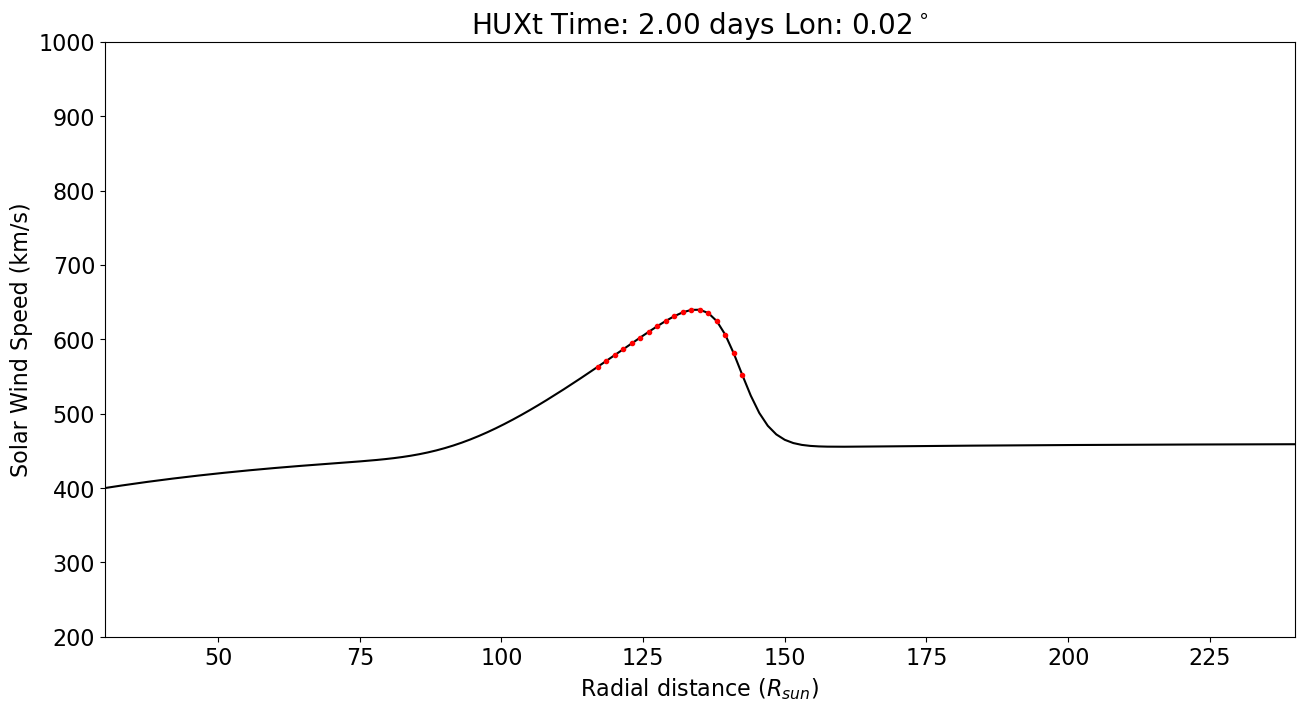

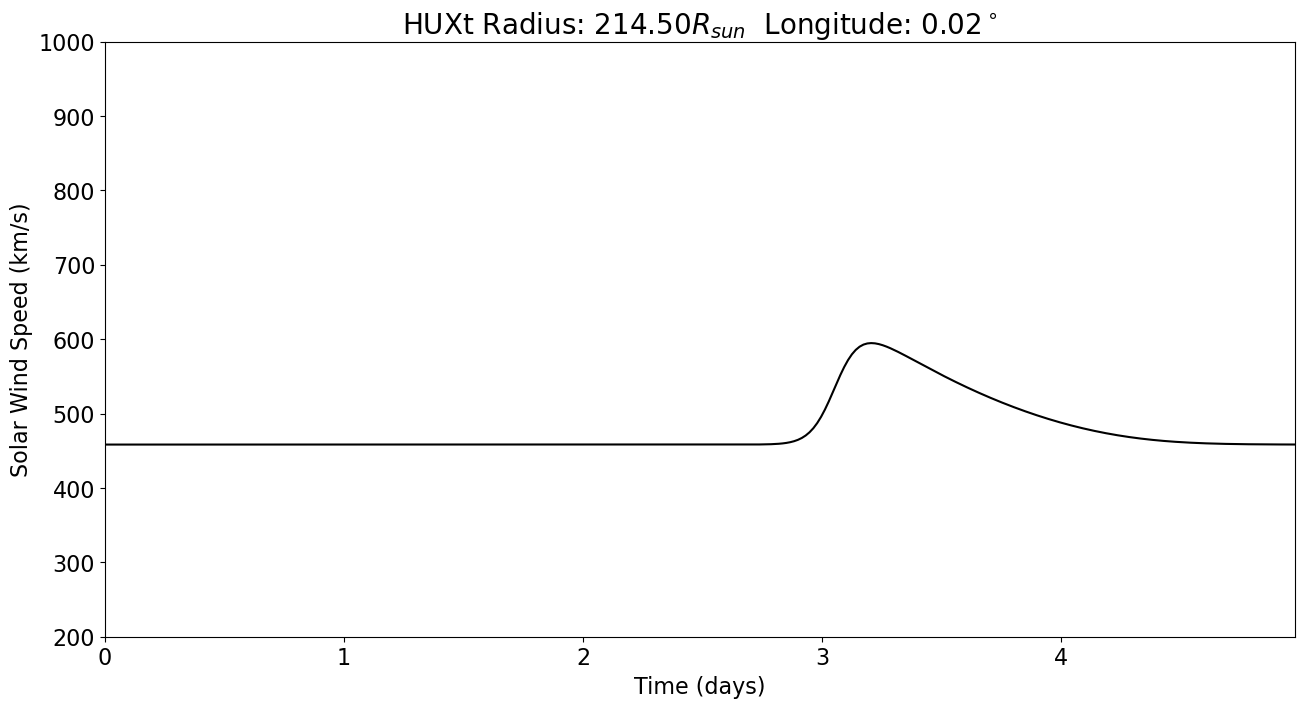

In [3]:
# EXAMPLE 2
# Set up a ConeCME that launches half a day after the simulation begins, at 0 longitude, 30 degree width, speed 850km/s and thickness=5 solar radii
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=850*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
#Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=5*u.day, dt_scale=4)

# Run the model, and this time save the results to file.
model.solve(cme_list, save=True, tag='1d_conecme_test')

# Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# Save both to file as well. These are saved in HUXt>figures>HUXt1D
t = 2*u.day
HA.plot_radial(model, t, lon=0.0*u.deg, save=True)

r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')

No initiation time specified. Defaulting to start of CR2000, 20/2/2003


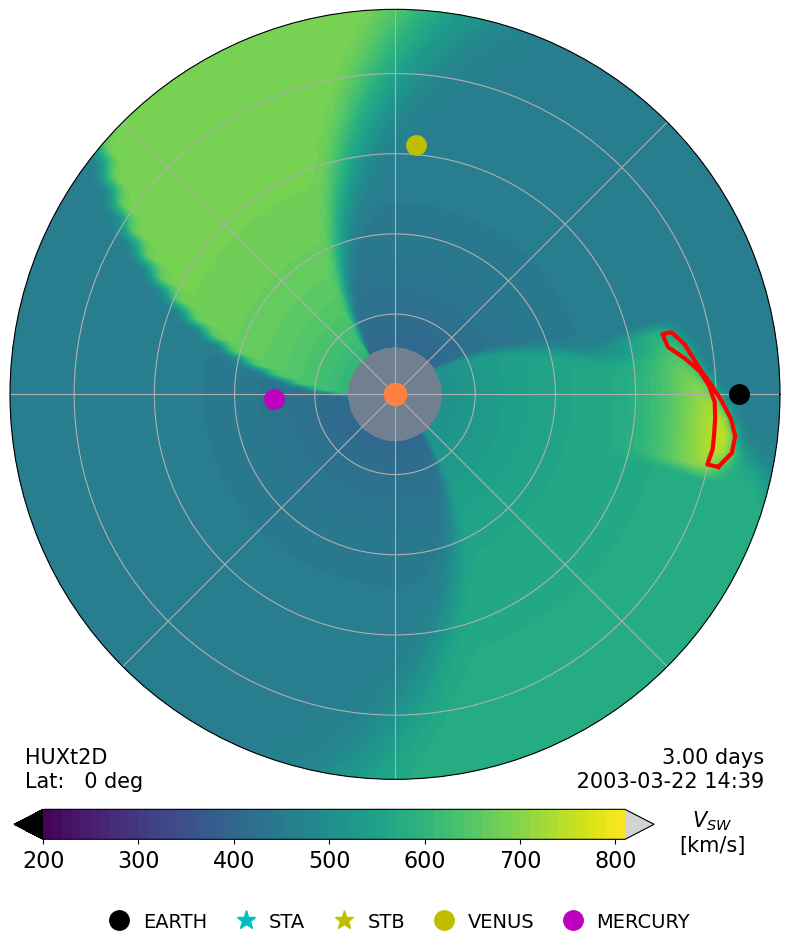

In [4]:
#EXAMPLE 3
#Form boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 500 * (u.km/u.s)

#  Add a CME
cme = H.ConeCME(t_launch=1*u.day, longitude=360*u.deg, latitude = 0*u.deg, width=30*u.deg, v=1500*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
model = H.HUXt(v_boundary=v_boundary, latitude = 0*u.deg, simtime=6*u.day, dt_scale=4)

model.solve(cme_list, tag='cone_cme_test')

# Plot this out
t_interest = 3*u.day
fig, ax = HA.plot(model, t_interest)

### Task two: next, try reproducing example four, and changing the carrington rotation number to se the model change. 

#### For each carrington roation you try, plot the boundary condition on one figure to see how different they are. 


In [5]:
df = helpers.get_prograde_df(22)
pd.set_option('display.max_rows', None)
#print(df)
df['longitude'].agg(['min', 'max'])

min    142.536926
max    313.233211
Name: longitude, dtype: float64

In [6]:
spacing = df['longitude'].diff().dropna()
print(f"Average longitude spacing: {spacing.mean():.3f}°")
print(f"Total PSP points: {len(df)}")

Average longitude spacing: 0.404°
Total PSP points: 423


Files already exist for CR2292


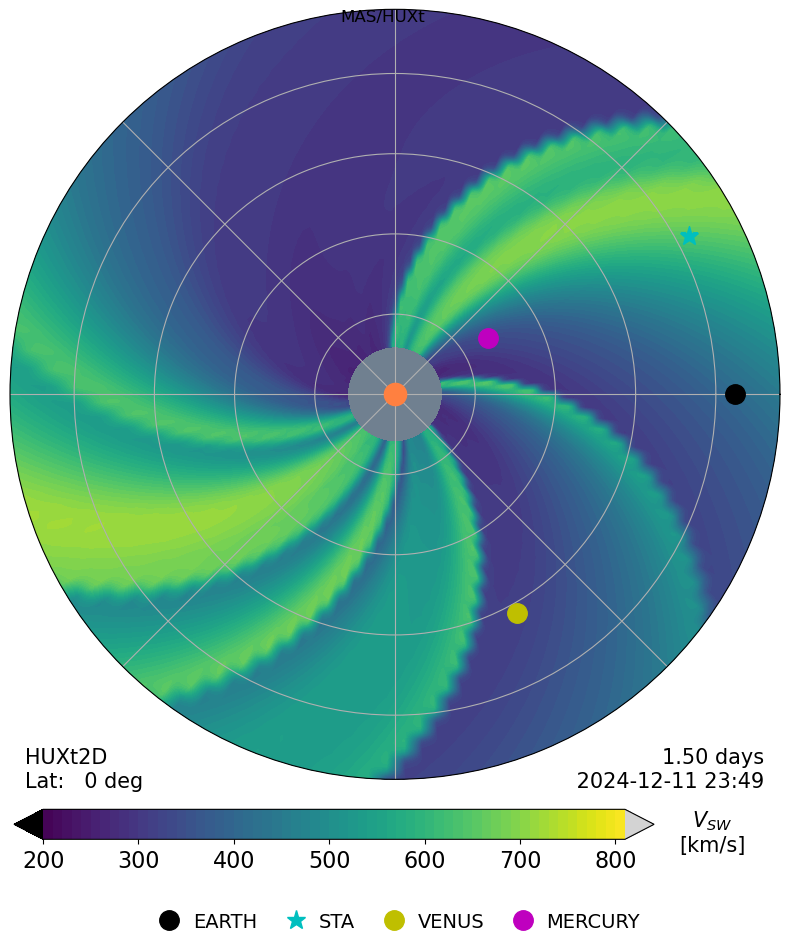

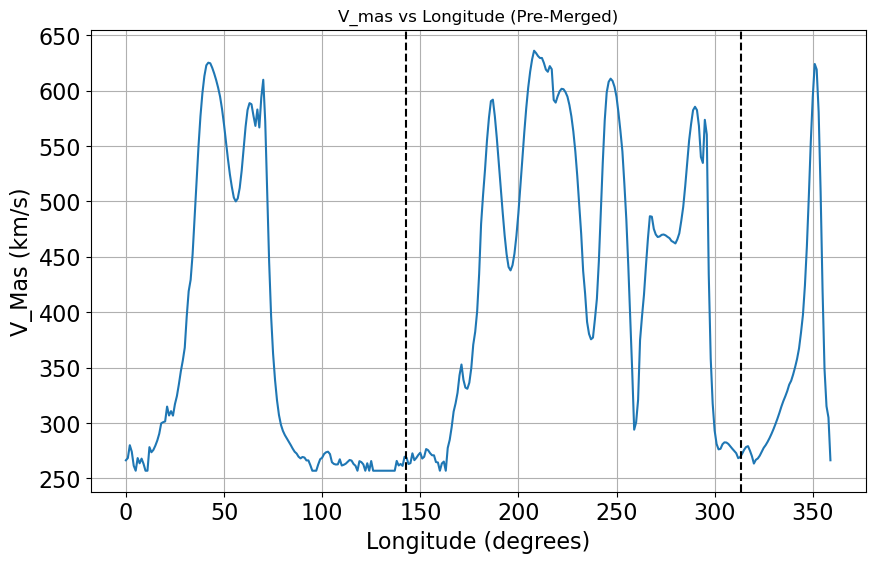

In [7]:
# EXAMPLE 4
#HUXt can be easily initiated MAS, by specifying a carrington rotation number. Data are downloaded from the Pred Sci Inc archive on demand
cr = 2292
v_mas = Hin.get_MAS_long_profile(cr, 0.0*u.deg)

#MAS solutions are at 30 rS
model = H.HUXt(v_boundary=v_mas, cr_num=cr, simtime=5*u.day, dt_scale=4, r_min = 30*u.solRad)
model.solve([])

# Plot the solution 
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('MAS/HUXt')

# V_mas vs Lon plot with margins that PSP data will go into
lon_array = np.linspace(0,359,len(v_mas))
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(lon_array,v_mas)

ax.set(xlabel='Longitude (degrees)',ylabel='V_Mas (km/s)',
       title='V_mas vs Longitude (Pre-Merged)')
ax.grid()
ax.axvline(x=142.54, color='black', linestyle='--', linewidth=1.5)
ax.axvline(x=313.23, color='black', linestyle='--', linewidth=1.5)

In [8]:
#print(len(v_mas))# trying to see resolution of v_mas so i know what to downsample to
#print(np.diff(lon_array))

In [9]:
# 360 pt grid from PSP longitude range
lon_min = int(df['longitude'].min())
lon_max = int(df['longitude'].max())

# Force 1-degree resolution
lon_uniform = np.arange(0, 360, 1)  # 0 to 359, 1-degree spacing

# interpolate (unitless output)
interp_func = interp1d(df['longitude'], df['Vr'], kind='linear', bounds_error=False, fill_value=np.nan)
vr_downsampled = interp_func(lon_uniform)  # <- stays as plain numpy array

# print values like v_mas
#print(vr_downsampled)
#print(len(vr_downsampled))
#print(np.diff(lon_uniform))

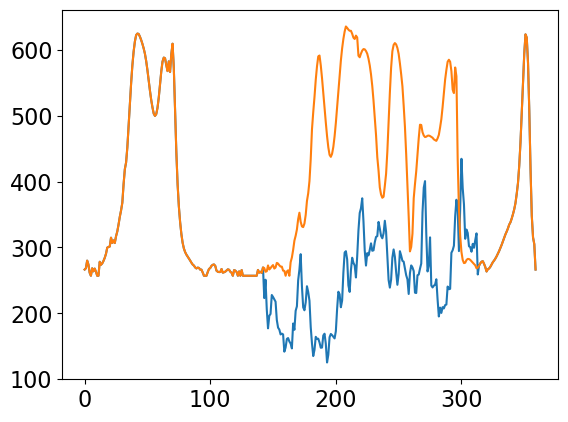

In [10]:
# fill NaNs with v_mas values
merged_values = np.where(np.isnan(vr_downsampled), v_mas.value, vr_downsampled)

# Re-attach the units (assuming v_mas is in km/s)
v_merged = merged_values * v_mas.unit

plt.plot(v_merged)
plt.plot(v_mas)

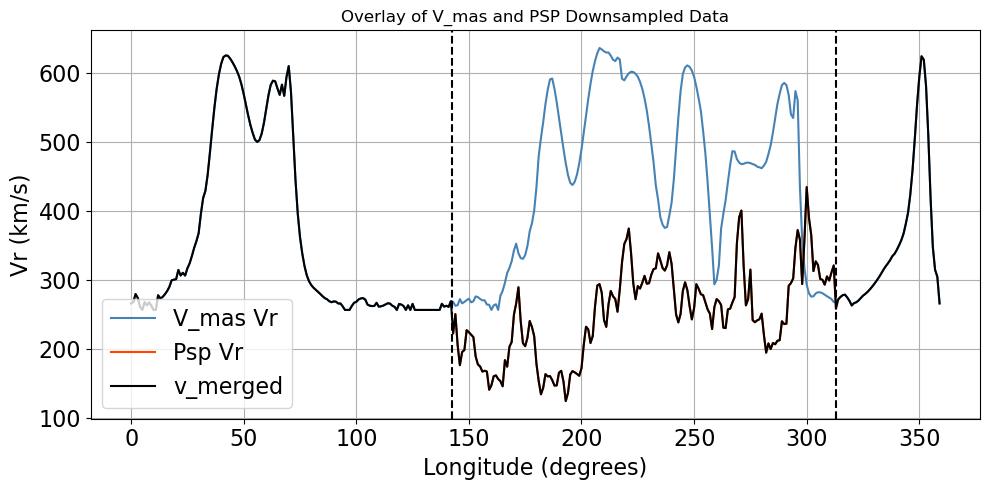

In [11]:
# create the longitude grid
lon_grid = np.arange(0, 360)

# plot original v-mas
plt.figure(figsize=(10, 5))
plt.plot(lon_grid, v_mas, label='V_mas Vr', color='steelblue')

# plot downsampled PSP
plt.plot(lon_uniform, vr_downsampled, label='Psp Vr', color='orangered')

plt.plot(v_merged, label='v_merged',color='black')
# vertical lines for longitude range
plt.axvline(x=142.54, color='black', linestyle='--', linewidth=1.5)
plt.axvline(x=313.23, color='black', linestyle='--', linewidth=1.5)

plt.xlabel("Longitude (degrees)")
plt.ylabel("Vr (km/s)")
plt.title("Overlay of V_mas and PSP Downsampled Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Error, input lon outside range of model longitudes. Defaulting to closest longitude


(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'HUXt Radius: 214.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

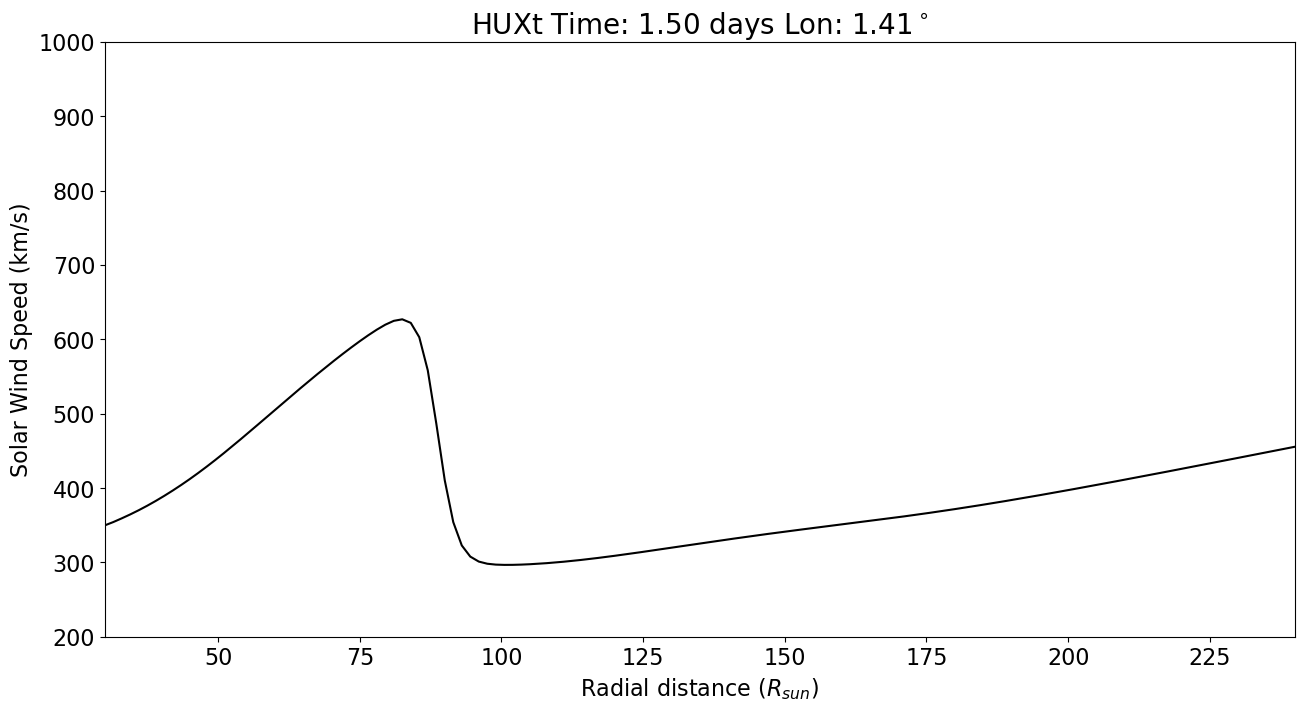

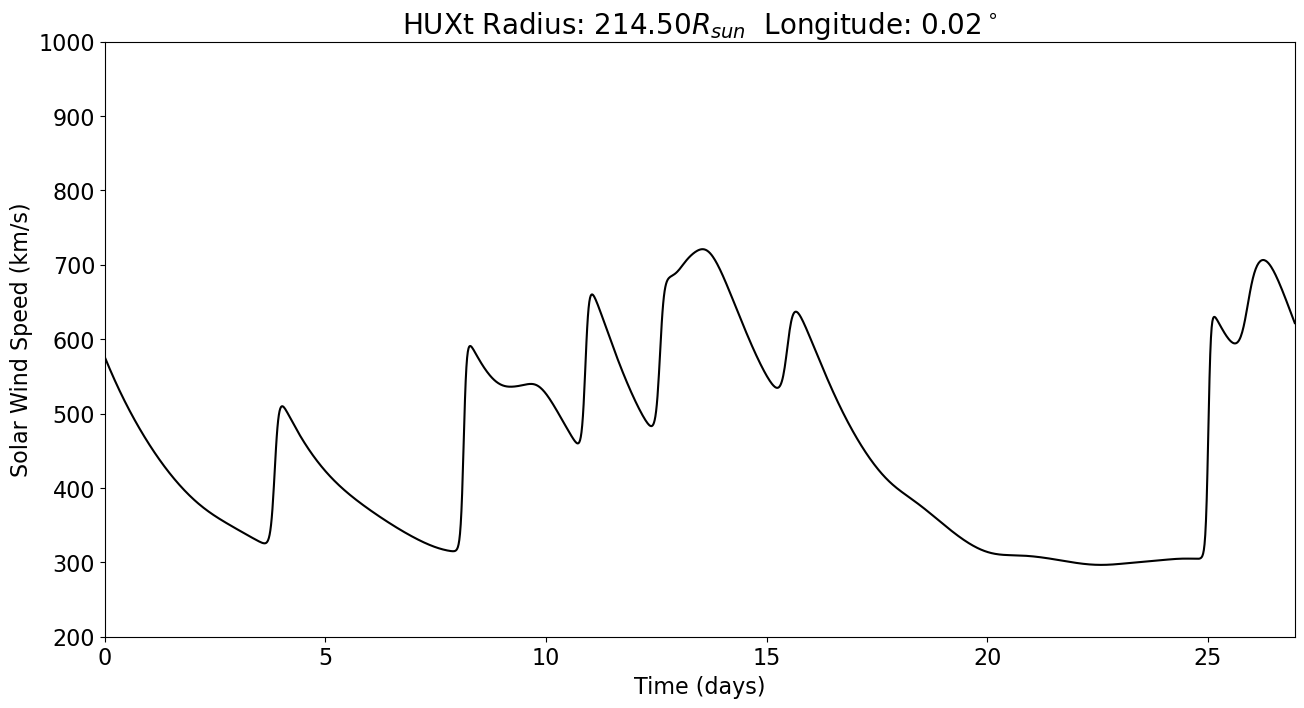

In [12]:
model = H.HUXt(v_boundary=v_mas, cr_num=2292, simtime=27*u.day, dt_scale=4, r_min=30*u.solRad)

cme_list = []
model.solve(cme_list)

t = 1.5 * u.day
lon = 0.0 * u.deg  
fig = HA.plot_radial(model, t, lon=lon)


r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')


Error, input lon outside range of model longitudes. Defaulting to closest longitude


(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'HUXt Radius: 214.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

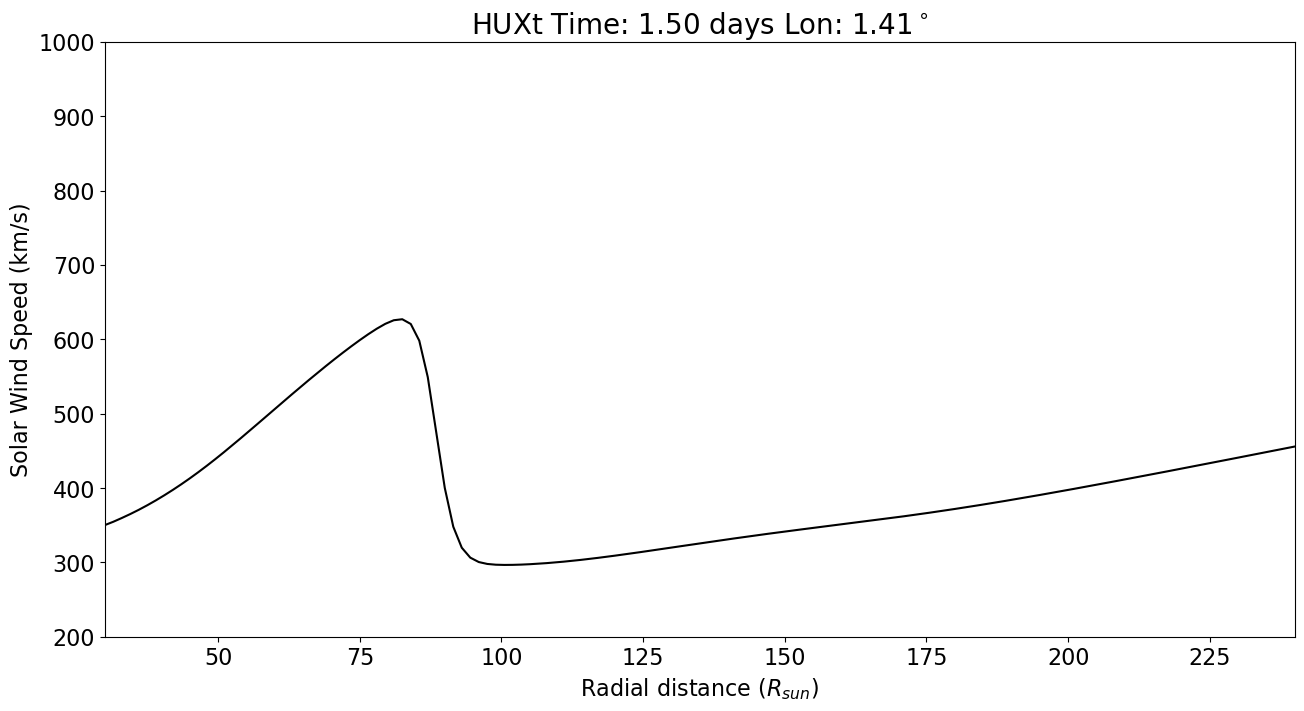

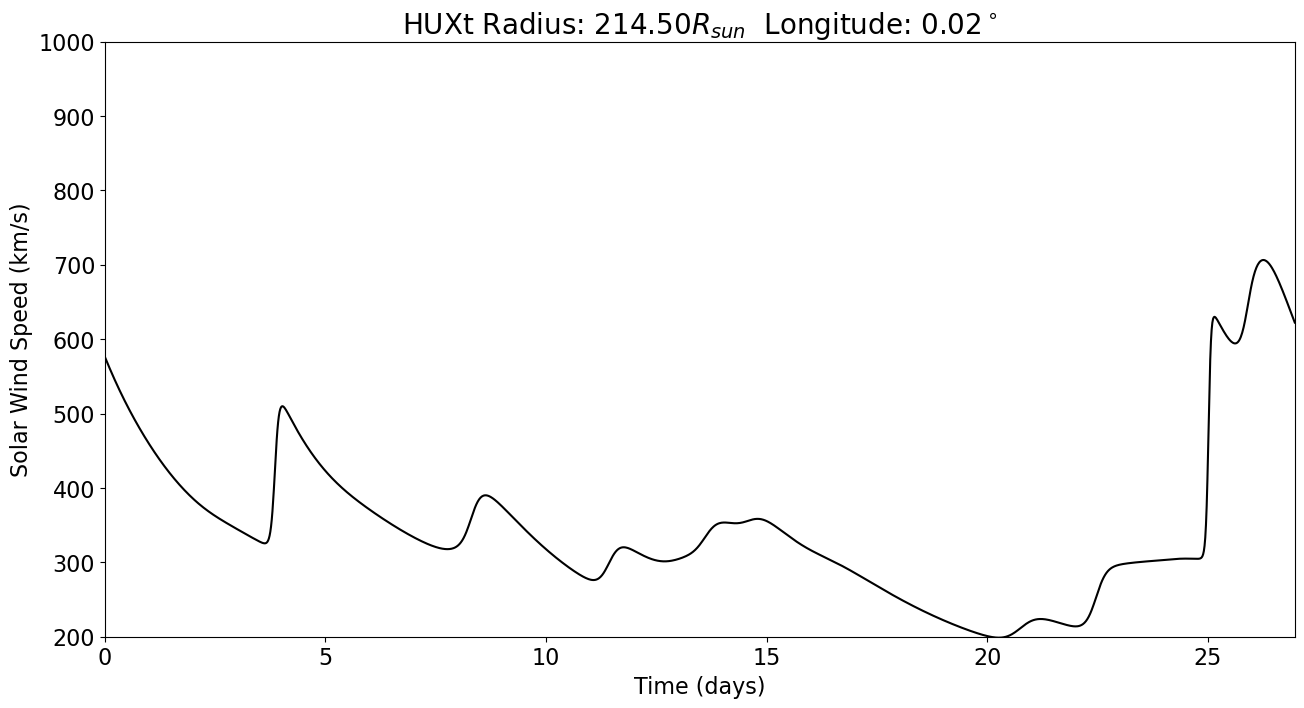

In [13]:
model = H.HUXt(v_boundary=v_merged, cr_num=2292, simtime=27*u.day, dt_scale=4, r_min=30*u.solRad)

cme_list = []
model.solve(cme_list)

t = 1.5 * u.day
lon = 0.0 * u.deg  
fig = HA.plot_radial(model, t, lon=lon)


r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')


In [14]:

def get_v_merged(encounter_number, v_mas):
    """
    Returns the HUXt-ready v_merged boundary and auto-detects Carrington rotation number
    based on the encounter time.
    """
    # Step 1: Load PSP prograde data
    df = helpers.get_prograde_df(encounter_number)

    # Step 2: Infer Carrington Rotation number
    def get_cr_number_from_time(timestamp):
        cr1_start = Time('1853-11-09 12:00:00', format='iso', scale='utc')
        cr_length = 27.2753  # days
        t = Time(timestamp)
        return int(((t - cr1_start).to('day').value) / cr_length) + 1

    cr_number = get_cr_number_from_time(df['time'].iloc[0])

    # Step 3: Interpolate Vr onto 1-degree longitude grid
    lon_uniform = np.arange(0, 360, 1)
    interp_func = interp1d(df['longitude'], df['Vr'], kind='linear',
                           bounds_error=False, fill_value=np.nan)
    vr_downsampled = interp_func(lon_uniform)

    # Step 4: Merge with v_mas to fill gaps
    v_merged_values = np.where(np.isnan(vr_downsampled), v_mas.value, vr_downsampled)
    v_merged = v_merged_values * v_mas.unit

    # Step 5: Return v_merged and Carrington rotation number
    return v_merged, cr_number



/opt/anaconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


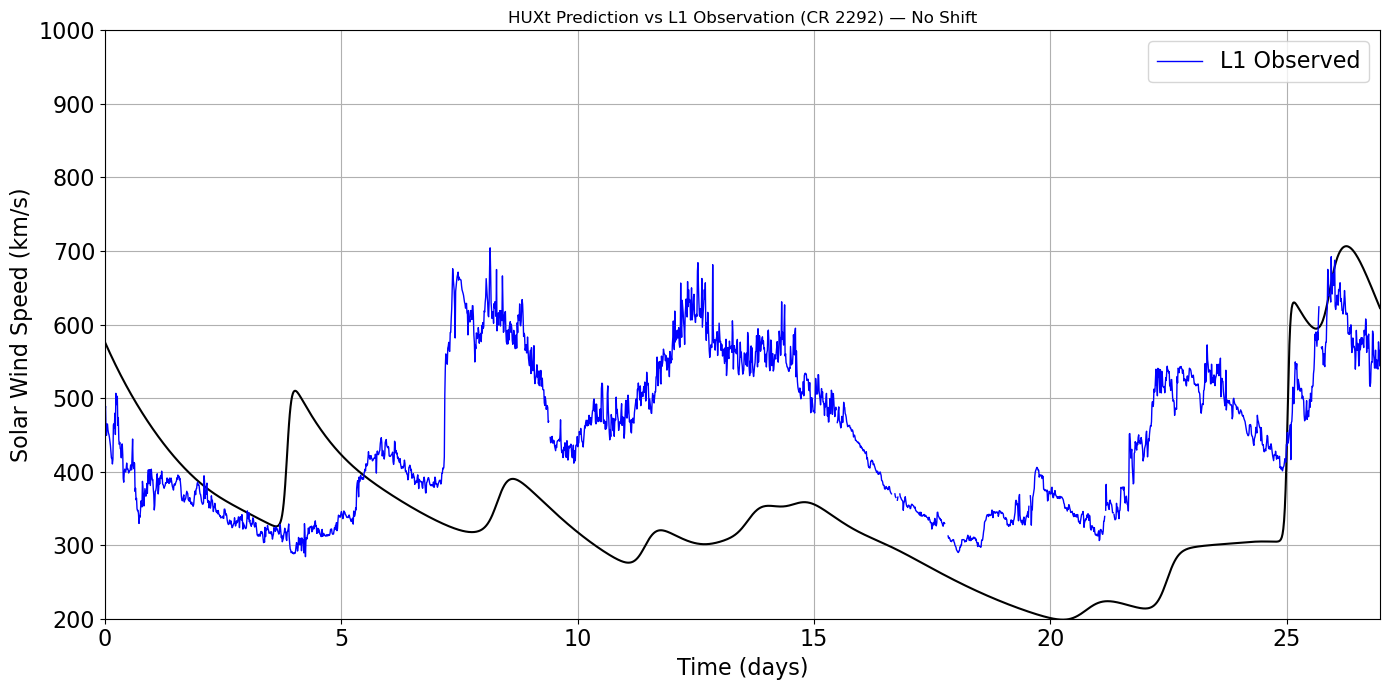

In [24]:

enc = 22
df = pd.read_csv(f'../data/E{enc:02d}.csv')
df.columns = [col.replace('-', '_').replace('–', '_').strip() for col in df.columns]
df['Times'] = pd.to_datetime(df['Times'], errors='coerce')

cr_start = pd.to_datetime('2024-12-10')
cr_end = pd.to_datetime('2025-01-06')
df = df[(df['Times'] >= cr_start) & (df['Times'] <= cr_end)].copy()

# --- Time in days relative to CR start ---
df['Time_days'] = (df['Times'] - cr_start).dt.total_seconds() / 86400

# # --- Time-shifted to account for propagation delay (~1 AU / 400 km/s) ---
# df['Time_shifted'] = df['Time_days'] - (1.0 * u.AU / (400 * u.km/u.s)).to(u.day).value

# --- Run HUXt with v_merged ---
v_merged, cr = get_v_merged(encounter_number=22, v_mas=v_mas)
model = H.HUXt(v_boundary=v_merged, cr_num=cr, simtime=27*u.day, dt_scale=4, r_min=30*u.solRad)
model.solve([])

# --- Plot HUXt + L1 without time shift ---
HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')
plt.plot(df['Time_days'], df['Vpr_L1'], label='L1 Observed', color='blue', linewidth=1)

plt.xlabel("Time (days)")
plt.ylabel("Solar Wind Speed (km/s)")
plt.title("HUXt Prediction vs L1 Observation (CR 2292) — No Shift")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [ ]:
# example 4 (cont.) 
# read in the data
cr = 2255

demo_dir = H._setup_dirs_()['example_inputs']

wsafilepath = os.path.join(demo_dir, '2022-02-24T22Z.wsa.gong.fits')
pfssfilepath = os.path.join(demo_dir, 'windbound_b_pfss20220224.22.nc')
cortomfilepath = os.path.join(demo_dir, 'tomo_sta_cor2_20240224153428_8-0.dat')
dumfricfilepath = os.path.join(demo_dir, 'windbound_b20220224.12.nc')

v_wsa = Hin.get_WSA_long_profile(wsafilepath, lat=0.0 * u.deg)
v_pfss = Hin.get_PFSS_long_profile(pfssfilepath, lat=0.0 * u.deg)
v_dumfric = Hin.get_PFSS_long_profile(dumfricfilepath, lat=0.0 * u.deg) #DUMFRIC uses the PFSS reader too
v_cortom = Hin.get_CorTom_long_profile(cortomfilepath, lat=0.0 * u.deg)

# set up and run the models. WSA and PFSS maps are at 21.5 rS, CorTom at 8 rS
model = H.HUXt(v_boundary=v_wsa, cr_num=cr, simtime=5*u.day, dt_scale=4, r_min = 21.5*u.solRad)
model.solve([])
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('WSA/HUXt')

model = H.HUXt(v_boundary=v_pfss, cr_num=cr, simtime=5*u.day, dt_scale=4, r_min = 21.5*u.solRad)
model.solve([])
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('PFSS/HUXt')

model = H.HUXt(v_boundary=v_dumfric, cr_num=cr, simtime=27*u.day, dt_scale=4, r_min = 21.5*u.solRad)
model.solve([])
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('DUMFRIC/HUXt')

model = H.HUXt(v_boundary=v_cortom, cr_num=cr, simtime=27*u.day, dt_scale=4, r_min = 8*u.solRad)
model.solve([])
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('CorTom/HUXt')

In [ ]:
# huxt_inputs also has a function to create coneCME objects from the cone2bc.in files that are used to drive Enlil.

In [ ]:
demo_dir = H._setup_dirs_()['example_inputs']

wsafilepath = os.path.join(demo_dir, 'wsa_gong_2024050906.fits')
v_wsa = Hin.get_WSA_long_profile(wsafilepath, lat=0.0 * u.deg)

time = datetime.datetime(2024, 5, 9, 6)
cr, cr_lon_init = Hin.datetime2huxtinputs(time)

model = H.HUXt(v_boundary=v_wsa, cr_num=cr, cr_lon_init=cr_lon_init, simtime=5*u.day, dt_scale=4, r_min = 21.5*u.solRad)

conefilepath = os.path.join(demo_dir, 'cone_cme_2024050906.in')
cme_list = Hin.ConeFile_to_ConeCME_list(model, conefilepath)

for cme in cme_list:
    print(cme.parameter_array())
    #print(cme.compute_arrival_at_body('EARTH'))

model.solve(cme_list)
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('WSA/HUXt')